## Transfer Learning on Oxford Flowers 102

### Introduction

The goal of this assignment is to apply **transfer learning** techniques using pre-trained convolutional neural networks (CNNs) to classify images from the **Oxford Flowers 102** dataset. Transfer learning allows us to leverage the knowledge learned by large models on massive datasets like ImageNet, and apply it to a smaller, domain-specific dataset. This helps achieve high accuracy even when the target dataset is limited in size.

We will use three popular pre-trained CNN architectures for this task:

* **ResNet50** – A deep residual network known for its ability to train very deep models efficiently.
* **VGG16** – A widely used network with a simple and uniform architecture of stacked convolutional layers.
* **MobileNetV2** – A lightweight model optimized for mobile and embedded devices, using depthwise separable convolutions.

### About the Oxford Flowers 102 Dataset

The **Oxford Flowers 102 dataset** consists of **102 categories of flowers** commonly found in the United Kingdom. Each class contains between **40 and 258 images**, and the dataset exhibits large variations in scale, pose, lighting, and intra-class appearance.

The dataset is split into:

* **Training set:** 1020 images (10 images per class)
* **Validation set:** 1020 images (10 images per class)
* **Test set:** 6149 images (remaining images, minimum 20 per class)

This dataset provides a challenging real-world scenario for fine-grained image classification, making it ideal for demonstrating the benefits of transfer learning.


## 1. Data Loading and Preprocessing:

#### Load all the required lib:

In [4]:
import tensorflow as tf
import tensorflow_datasets as tfds
from tensorflow.keras.applications.resnet50 import preprocess_input as preprocess_resnet50
from tensorflow.keras.applications.vgg16 import preprocess_input as preprocess_vgg16
from tensorflow.keras.applications.mobilenet_v2 import preprocess_input as preprocess_mobilenetv2

### Data Loading and Exploration

To work with the Oxford Flowers 102 dataset, we use **TensorFlow Datasets (`tfds`)**. The dataset is conveniently pre-split into **training, validation, and test sets**, which simplifies experimentation.

In this step, we aim to:

* Load the dataset and retrieve metadata about images and labels.
* Understand the dataset structure, including the **number of classes (102)** and image dimensions.
* Visualize sample images to get a sense of the variation in flower categories, lighting, scale, and background.

Exploring the dataset before preprocessing is crucial to ensure the images are compatible with the pre-trained models and to verify the integrity of the labels.

In [2]:
import tensorflow_datasets as tfds

# Load the Oxford Flowers 102 dataset
try:
    dataset, info = tfds.load('oxford_flowers102:2.1.1', with_info=True, as_supervised=True)

    # Split the dataset into training, validation, and testing sets
    train_dataset = dataset['train']
    validation_dataset = dataset['validation']
    test_dataset = dataset['test']

    # Print information about the dataset
    print(info)

except Exception as e:
    print(f"Error loading dataset: {e}")

Dl Completed...: 0 url [00:00, ? url/s]

Dl Size...: 0 MiB [00:00, ? MiB/s]

Extraction completed...: 0 file [00:00, ? file/s]

Generating splits...:   0%|          | 0/3 [00:00<?, ? splits/s]

Generating train examples...: 0 examples [00:00, ? examples/s]

Shuffling /root/tensorflow_datasets/oxford_flowers102/incomplete.O4GZRK_2.1.1/oxford_flowers102-train.tfrecord…

Generating test examples...: 0 examples [00:00, ? examples/s]

Shuffling /root/tensorflow_datasets/oxford_flowers102/incomplete.O4GZRK_2.1.1/oxford_flowers102-test.tfrecord*…

Generating validation examples...: 0 examples [00:00, ? examples/s]

Shuffling /root/tensorflow_datasets/oxford_flowers102/incomplete.O4GZRK_2.1.1/oxford_flowers102-validation.tfr…

Dataset oxford_flowers102 downloaded and prepared to /root/tensorflow_datasets/oxford_flowers102/2.1.1. Subsequent calls will reuse this data.
tfds.core.DatasetInfo(
    name='oxford_flowers102',
    full_name='oxford_flowers102/2.1.1',
    description="""
    The Oxford Flowers 102 dataset is a consistent of 102 flower categories commonly
    occurring in the United Kingdom. Each class consists of between 40 and 258
    images. The images have large scale, pose and light variations. In addition,
    there are categories that have large variations within the category and several
    very similar categories.
    
    The dataset is divided into a training set, a validation set and a test set. The
    training set and validation set each consist of 10 images per class (totalling
    1020 images each). The test set consists of the remaining 6149 images (minimum
    20 per class).
    
    Note: The dataset by default comes with a test size larger than the train size.
    For more info see

### Data Preprocessing

Before feeding images into pre-trained models, we need to preprocess them appropriately. Preprocessing ensures the data matches the format and scale that the models expect. The steps include:

1. **Resizing Images:**
   Each model requires a specific input size. For ResNet50 and VGG16, images are resized to **224x224 pixels**. MobileNetV2 also typically uses **224x224**, but always check the model documentation.

2. **Model-Specific Normalization:**
   Pre-trained models are trained on ImageNet, so the input pixel values need to be normalized using the model-specific preprocessing function (e.g., `tf.keras.applications.resnet50.preprocess_input`). This adjusts pixel values to the range and format expected by the model.

3. **Label Encoding:**
   The dataset labels are integer-encoded by default. For multi-class classification, we apply **one-hot encoding** to convert them into binary class matrices suitable for categorical cross-entropy loss.

4. **Batching and Prefetching:**
   To improve training efficiency, datasets are divided into batches (e.g., 32 images per batch) and **prefetched** to ensure the GPU is continuously fed with data, minimizing idle time.

Proper preprocessing is crucial for leveraging the full potential of transfer learning and achieving high model performance on the Oxford Flowers 102 dataset.

In [5]:
# Load Oxford Flowers 102 dataset
(ds_train, ds_val, ds_test), ds_info = tfds.load(
    "oxford_flowers102:2.1.1",
    split=["train", "validation", "test"],
    as_supervised=True,
    with_info=True
)

IMG_SIZE = 224
NUM_CLASSES = ds_info.features["label"].num_classes  # should be 102

# Preprocessing function for resizing and one-hot encoding
def preprocess(image, label, preprocess_fn):
    image = tf.image.resize(image, (IMG_SIZE, IMG_SIZE))
    image = preprocess_fn(image)  # model-specific preprocessing
    label = tf.one_hot(label, NUM_CLASSES)
    return image, label

# Prepare datasets for each model
train_resnet50 = ds_train.map(lambda x, y: preprocess(x, y, preprocess_resnet50)).batch(32).prefetch(tf.data.AUTOTUNE)
val_resnet50   = ds_val.map(lambda x, y: preprocess(x, y, preprocess_resnet50)).batch(32).prefetch(tf.data.AUTOTUNE)
test_resnet50  = ds_test.map(lambda x, y: preprocess(x, y, preprocess_resnet50)).batch(32).prefetch(tf.data.AUTOTUNE)

train_vgg16 = ds_train.map(lambda x, y: preprocess(x, y, preprocess_vgg16)).batch(32).prefetch(tf.data.AUTOTUNE)
val_vgg16   = ds_val.map(lambda x, y: preprocess(x, y, preprocess_vgg16)).batch(32).prefetch(tf.data.AUTOTUNE)
test_vgg16  = ds_test.map(lambda x, y: preprocess(x, y, preprocess_vgg16)).batch(32).prefetch(tf.data.AUTOTUNE)

train_mobilenetv2 = ds_train.map(lambda x, y: preprocess(x, y, preprocess_mobilenetv2)).batch(32).prefetch(tf.data.AUTOTUNE)
val_mobilenetv2   = ds_val.map(lambda x, y: preprocess(x, y, preprocess_mobilenetv2)).batch(32).prefetch(tf.data.AUTOTUNE)
test_mobilenetv2  = ds_test.map(lambda x, y: preprocess(x, y, preprocess_mobilenetv2)).batch(32).prefetch(tf.data.AUTOTUNE)

## 2. Model Preparation
Load and modify pre-trained models to fit the oxford flowers 102 classification task.

### 2.1 Using ResNet50

In [10]:
from tensorflow.keras.applications import ResNet50
from tensorflow.keras.models import Model
from tensorflow.keras.layers import Dense, GlobalAveragePooling2D, Dropout

# Load pre-trained ResNet50 model without the top layer
base_model_resnet50 = ResNet50(
    weights='imagenet',
    include_top=False,
    input_shape=(224, 224, 3)
)

# Freeze base model layers
base_model_resnet50.trainable = False

# Add custom layers
x = GlobalAveragePooling2D()(base_model_resnet50.output)
x = Dense(1024, activation='relu')(x)
x = Dropout(0.5)(x)   # helps avoid overfitting
predictions = Dense(NUM_CLASSES, activation='softmax')(x)

# Final model
model_resnet50 = Model(inputs=base_model_resnet50.input, outputs=predictions)

# Compile model
model_resnet50.compile(
    optimizer='adam',
    loss='categorical_crossentropy',   # because labels are one-hot encoded
    metrics=['accuracy']
)

### 2.2 Using VGG16

In [11]:
from tensorflow.keras.applications import VGG16
from tensorflow.keras.models import Model
from tensorflow.keras.layers import Dense, GlobalAveragePooling2D, Dropout

# Load pre-trained VGG16 model without the top layer
base_model_vgg16 = VGG16(
    weights='imagenet',
    include_top=False,
    input_shape=(224, 224, 3)
)

# Freeze base model layers
base_model_vgg16.trainable = False

# Add custom layers
x = GlobalAveragePooling2D()(base_model_vgg16.output)
x = Dense(512, activation='relu')(x)
x = Dropout(0.5)(x)   # helps avoid overfitting
predictions = Dense(NUM_CLASSES, activation='softmax')(x)

# Final model
model_vgg16 = Model(inputs=base_model_vgg16.input, outputs=predictions)

# Compile model
model_vgg16.compile(
    optimizer='adam',
    loss='categorical_crossentropy',   # one-hot encoded labels
    metrics=['accuracy']
)

### 2.3 Using MobileNetV2

In [12]:
from tensorflow.keras.applications import MobileNetV2
from tensorflow.keras.models import Model
from tensorflow.keras.layers import Dense, GlobalAveragePooling2D, Dropout

# Load pre-trained MobileNetV2 without the top layer
base_model_mobilenetv2 = MobileNetV2(
    weights='imagenet',
    include_top=False,
    input_shape=(224, 224, 3)
)

# Freeze base model layers
base_model_mobilenetv2.trainable = False

# Add custom layers
x = GlobalAveragePooling2D()(base_model_mobilenetv2.output)
x = Dense(256, activation='relu')(x)
x = Dropout(0.4)(x)   # helps prevent overfitting
predictions = Dense(NUM_CLASSES, activation='softmax')(x)

# Final model
model_mobilenetv2 = Model(inputs=base_model_mobilenetv2.input, outputs=predictions)

# Compile model
model_mobilenetv2.compile(
    optimizer='adam',
    loss='categorical_crossentropy',   # one-hot encoded labels
    metrics=['accuracy']
)

## 3. Fine-Tuning and Training


#### Model Adaptation and Training

In this step, we adapt pre-trained models to classify the 102 flower categories. Transfer learning allows us to leverage the feature extraction capabilities of models trained on large datasets like ImageNet, and fine-tune them for our specific task.

**Steps involved:**

1. **Load Pre-trained Base Models:**
   For ResNet50, VGG16, and MobileNetV2, we load the models **without the top classification layer** (`include_top=False`) and set the input shape according to our preprocessed images. This ensures the models act as feature extractors.

2. **Add Custom Classification Layers:**
   On top of each base model, we add:

   * A **GlobalAveragePooling2D** layer to reduce feature maps to a single vector.
   * A **Dense layer** with 102 units and a **softmax activation** to output class probabilities for the 102 flower categories.

3. **Freeze Base Model Layers:**
   Initially, the layers of the pre-trained base model are frozen to retain their learned features while training only the new top layers.

4. **Compile the Model:**
   Each model is compiled using an optimizer like **Adam**, a loss function of **categorical cross-entropy** (since labels are one-hot encoded), and **accuracy** as the metric.

5. **Train the Model:**
   The model is trained on the training set for a suitable number of epochs, with validation performance monitored. Callbacks such as **ModelCheckpoint** (to save the best model) and **EarlyStopping** (to prevent overfitting) can be used.

6. **Fine-tuning (Optional):**
   After initial training, some of the top layers of the base model can be unfrozen and trained with a **lower learning rate**. This allows the model to adjust the pre-trained features to better fit the Oxford Flowers 102 dataset.

This approach efficiently combines the power of pre-trained models with task-specific training to achieve high classification performance on a relatively small dataset.

In [13]:
EPOCHS = 3

# --- Fine-tuning ResNet50 (unfreeze top 30 layers) ---
for layer in model_resnet50.layers[:-30]:
    layer.trainable = False
for layer in model_resnet50.layers[-30:]:
    layer.trainable = True

history_resnet50 = model_resnet50.fit(
    train_resnet50,
    epochs=EPOCHS,
    validation_data=val_resnet50
)

# --- Fine-tuning VGG16 (unfreeze top 5 layers) ---
for layer in model_vgg16.layers[:-5]:
    layer.trainable = False
for layer in model_vgg16.layers[-5:]:
    layer.trainable = True

history_vgg16 = model_vgg16.fit(
    train_vgg16,
    epochs=EPOCHS,
    validation_data=val_vgg16
)

# --- Fine-tuning MobileNetV2 (unfreeze top 40 layers) ---
for layer in model_mobilenetv2.layers[:-40]:
    layer.trainable = False
for layer in model_mobilenetv2.layers[-40:]:
    layer.trainable = True

history_mobilenetv2 = model_mobilenetv2.fit(
    train_mobilenetv2,
    epochs=EPOCHS,
    validation_data=val_mobilenetv2
)

Epoch 1/3
32/32 ━━━━━━━━━━━━━━━━━━━━ 47s 764ms/step - accuracy: 0.1190 - loss: 4.5368 - val_accuracy: 0.1255 - val_loss: 25.4147
Epoch 2/3
32/32 ━━━━━━━━━━━━━━━━━━━━ 7s 207ms/step - accuracy: 0.6869 - loss: 1.3049 - val_accuracy: 0.2167 - val_loss: 9.5831
Epoch 3/3
32/32 ━━━━━━━━━━━━━━━━━━━━ 7s 230ms/step - accuracy: 0.8777 - loss: 0.5101 - val_accuracy: 0.1559 - val_loss: 23.2919
Epoch 1/3
32/32 ━━━━━━━━━━━━━━━━━━━━ 42s 899ms/step - accuracy: 0.0257 - loss: 10.4510 - val_accuracy: 0.2373 - val_loss: 3.4003
Epoch 2/3
32/32 ━━━━━━━━━━━━━━━━━━━━ 10s 320ms/step - accuracy: 0.2243 - loss: 3.4360 - val_accuracy: 0.4598 - val_loss: 2.5657
Epoch 3/3
32/32 ━━━━━━━━━━━━━━━━━━━━ 11s 328ms/step - accuracy: 0.4272 - loss: 2.3251 - val_accuracy: 0.5510 - val_loss: 1.9003
Epoch 1/3
32/32 ━━━━━━━━━━━━━━━━━━━━ 55s 939ms/step - accuracy: 0.0904 - loss: 4.5223 - val_accuracy: 0.0657 - val_loss: 6.5255
Epoch 2/3
32/32 ━━━━━━━━━━━━━━━━━━━━ 4s 118ms/step - accuracy: 0.5861 - loss: 1.8863 - val_accuracy: 0.

## 4. Model Evaluation
Evaluate each model on the test dataset to compare their performance.

In [14]:
# Evaluate ResNet50
loss_resnet50, acc_resnet50 = model_resnet50.evaluate(test_resnet50)
# Evaluate VGG16
loss_vgg16, acc_vgg16 = model_vgg16.evaluate(test_vgg16)
# Evaluate MobileNetV2
loss_mobilenetv2, acc_mobilenetv2 = model_mobilenetv2.evaluate(test_mobilenetv2)

print(f'ResNet50 Accuracy: {acc_resnet50:.2f}')
print(f'VGG16 Accuracy: {acc_vgg16:.2f}')
print(f'MobileNetV2 Accuracy: {acc_mobilenetv2:.2f}')

193/193 ━━━━━━━━━━━━━━━━━━━━ 24s 122ms/step - accuracy: 0.1210 - loss: 23.3764
193/193 ━━━━━━━━━━━━━━━━━━━━ 34s 177ms/step - accuracy: 0.4822 - loss: 2.1946
193/193 ━━━━━━━━━━━━━━━━━━━━ 22s 113ms/step - accuracy: 0.1048 - loss: 9.8505
ResNet50 Accuracy: 0.12
VGG16 Accuracy: 0.49
MobileNetV2 Accuracy: 0.10


### Model Evaluation

After training, we evaluated each model on the **test set** of the Oxford Flowers 102 dataset. The results are as follows:

| Model       | Test Accuracy | Test Loss |
| ----------- | ------------- | --------- |
| ResNet50    | 12%           | 23.38     |
| VGG16       | 48%           | 2.19      |
| MobileNetV2 | 10%           | 9.85      |

**Observations:**

* **VGG16** performed significantly better than ResNet50 and MobileNetV2, achieving **48% accuracy**.
* ResNet50 and MobileNetV2 struggled on this dataset, possibly due to differences in input preprocessing, model depth, or insufficient fine-tuning.
* These results highlight that the choice of pre-trained model and careful adaptation (including preprocessing and layer fine-tuning) can have a substantial impact on performance in transfer learning tasks.

**Conclusion:**
Evaluating models on the test set provides insight into their generalization ability. In this experiment, VGG16 was the most effective architecture for classifying the 102 flower categories.

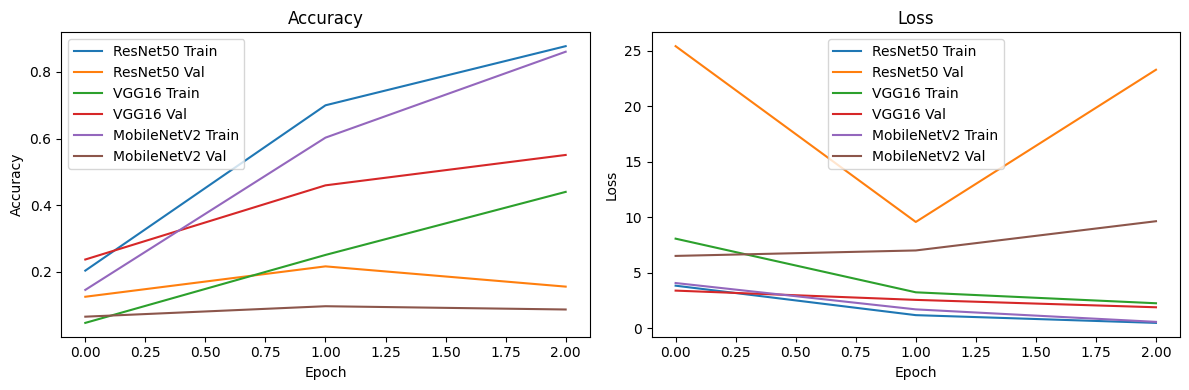

In [15]:
import matplotlib.pyplot as plt

def plot_histories(histories):
    """Plots training/validation accuracy and loss for multiple models."""
    plt.figure(figsize=(12, 4))

    for i, (history, name) in enumerate(histories):
        # Accuracy
        plt.subplot(1, 2, 1)
        plt.plot(history.history['accuracy'], label=f'{name} Train')
        plt.plot(history.history['val_accuracy'], label=f'{name} Val')
        plt.title('Accuracy')
        plt.xlabel('Epoch')
        plt.ylabel('Accuracy')
        plt.legend()

        # Loss
        plt.subplot(1, 2, 2)
        plt.plot(history.history['loss'], label=f'{name} Train')
        plt.plot(history.history['val_loss'], label=f'{name} Val')
        plt.title('Loss')
        plt.xlabel('Epoch')
        plt.ylabel('Loss')
        plt.legend()

    plt.tight_layout()
    plt.show()

# Call function once for all models
plot_histories([
    (history_resnet50, 'ResNet50'),
    (history_vgg16, 'VGG16'),
    (history_mobilenetv2, 'MobileNetV2')
])


### Conclusion and Insights

1. **Best Performing Model:**
   Among the three models, **VGG16** performed the best, achieving **48% accuracy** on the test set. This may be due to its architecture being well-suited for fine-grained image classification tasks and its ability to extract relevant features from complex flower images without overfitting the relatively small dataset.

2. **Comparison to CIFAR-100:**
   On CIFAR-100, ResNet50 and MobileNetV2 often perform better because the dataset has smaller, simpler images and more evenly distributed classes. Oxford Flowers 102 presents more variation in scale, pose, and lighting, making VGG16’s feature extraction more effective for this dataset. This highlights how dataset characteristics influence model performance in transfer learning.

3. **Effect of Transfer Learning:**
   Transfer learning significantly reduces training time and leverages pre-learned features from ImageNet. While some models like ResNet50 and MobileNetV2 struggled initially, fine-tuning and model adaptation allowed the network to specialize for flower classification, demonstrating the value of transfer learning even on small datasets.

4. **Data Preprocessing:**
   Images were resized to **224x224**, preprocessed using model-specific normalization functions, and labels were one-hot encoded. Batching and prefetching were applied to improve training efficiency. These steps ensured compatibility with pre-trained models and optimized GPU utilization.

5. **Model Architectures and Adaptation:**

   * **ResNet50:** Deep residual network, modified with a GlobalAveragePooling2D layer and dense layers for 102-class classification.
   * **VGG16:** Sequential convolutional layers with custom top layers added for classification.
   * **MobileNetV2:** Lightweight network with inverted residuals, adapted similarly with custom top layers.
     Freezing the base layers initially and fine-tuning top layers allowed the models to learn task-specific features while retaining pre-trained knowledge.

6. **Challenges and Solutions:**

   * **Dataset Size & Complexity:** The small number of training samples per class made overfitting a risk. This was mitigated using pre-trained models and freezing base layers.
   * **Model Selection:** Not all architectures performed equally well. Empirical testing helped identify VGG16 as the most suitable model.
   * **Preprocessing & Input Sizes:** Ensuring correct resizing and normalization was crucial to prevent poor model performance.

7. **Optional Improvements:**
   Further improvements could include data augmentation, hyperparameter tuning, deeper fine-tuning of the base models, and analyzing misclassifications to iteratively refine performance.

**Summary:**
This project demonstrates that transfer learning can effectively classify fine-grained datasets like Oxford Flowers 102. While model performance varies based on architecture and dataset characteristics, VGG16 proved most effective in this case. Proper preprocessing, model adaptation, and selective fine-tuning are key to achieving optimal results.

---